Using device: cuda
labels
colon_aca    5000
colon_n      5000
lung_aca     5000
lung_scc     5000
lung_n       5000
Name: count, dtype: int64
Total after sampling: 25000
train_df: 20000, test_df: 2500, valid_df: 2500
Found 20000 images for training belonging to 5 classes
Found 2500 images for testing belonging to 5 classes
Found 2500 images for validating belonging to 5 classes


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/10] Train Loss: 0.0785  Train Acc: 0.9727  Val Loss: 0.0212  Val Acc: 0.9916
Model saved at /kaggle/working/best_pretrained_vit_model.pth!
Epoch [2/10] Train Loss: 0.0154  Train Acc: 0.9951  Val Loss: 0.0097  Val Acc: 0.9964
Model saved at /kaggle/working/best_pretrained_vit_model.pth!
Epoch [3/10] Train Loss: 0.0092  Train Acc: 0.9975  Val Loss: 0.0050  Val Acc: 0.9992
Model saved at /kaggle/working/best_pretrained_vit_model.pth!
Epoch [4/10] Train Loss: 0.0113  Train Acc: 0.9968  Val Loss: 0.0237  Val Acc: 0.9912
Epoch [5/10] Train Loss: 0.0059  Train Acc: 0.9986  Val Loss: 0.0035  Val Acc: 0.9992
Epoch [6/10] Train Loss: 0.0000  Train Acc: 1.0000  Val Loss: 0.0019  Val Acc: 0.9988
Epoch [7/10] Train Loss: 0.0000  Train Acc: 1.0000  Val Loss: 0.0016  Val Acc: 0.9996
Model saved at /kaggle/working/best_pretrained_vit_model.pth!
Epoch [8/10] Train Loss: 0.0000  Train Acc: 1.0000  Val Loss: 0.0016  Val Acc: 0.9996
Epoch [9/10] Train Loss: 0.0000  Train Acc: 1.0000  Val Loss: 0.

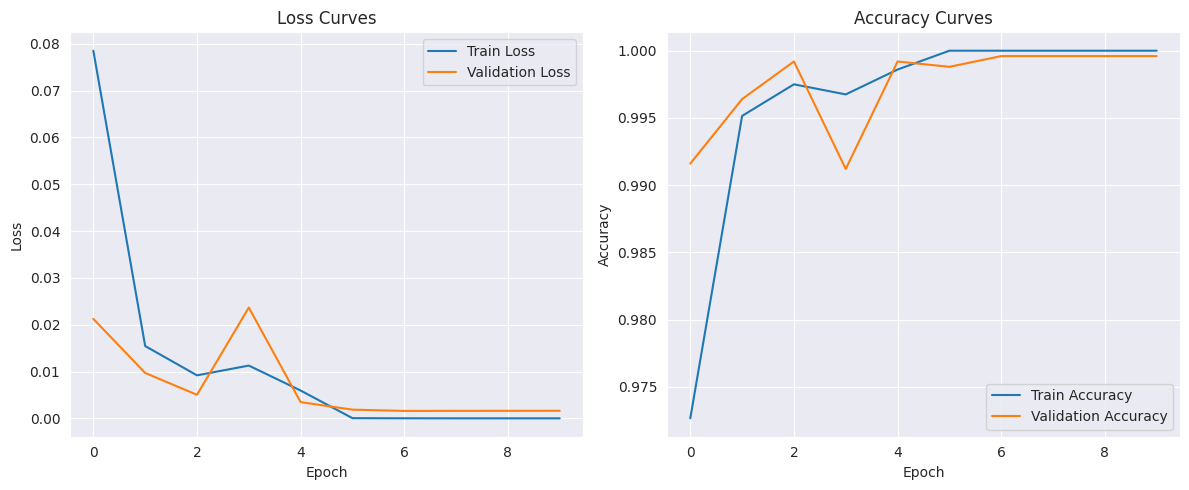

/tmp/ipykernel_31/3871059106.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Test Accuracy: 1.0000
Confusion Matrix:
 [[504   0   0   0   0]
 [  0 514   0   0   0]
 [  0   0 503   0   0]
 [  0   0   0 491   0]
 [  0   0   0   0 488]]
Classification Report:
               precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00       504
   colon_aca       1.00      1.00      1.00       514
    lung_aca       1.00      1.00      1.00       503
    lung_scc       1.00      1.00      1.00       491
     colon_n       1.00      1.00      1.00       488

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



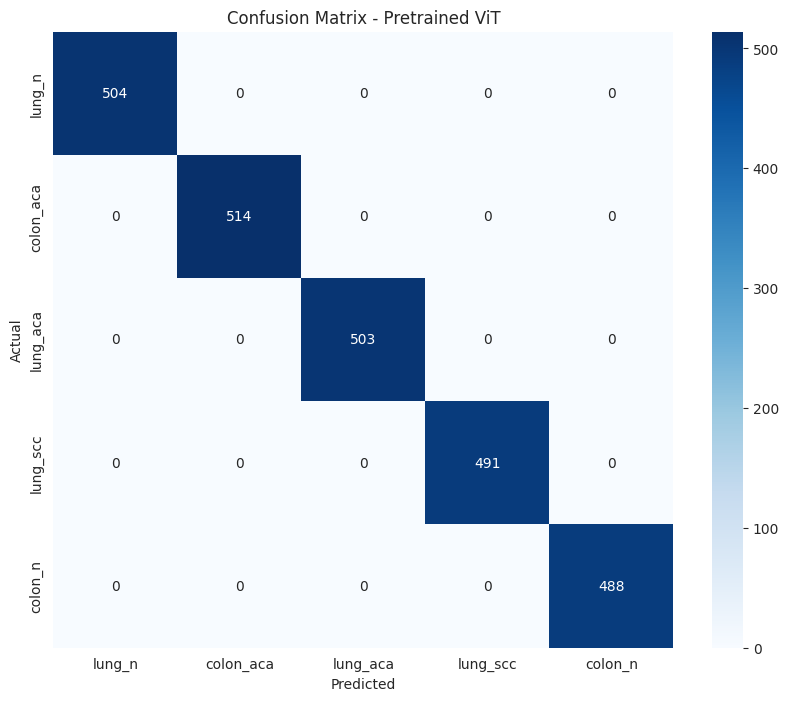

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import timm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style('darkgrid')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data preparation (using your existing code)
dir = r'/kaggle/input/lung-and-colon-data' 
file_paths = []
labels = []
for root, dirs, files in os.walk(dir):
    for classs in dirs:
        if classs in ["lung_image_sets", "colon_image_sets"]:
            continue  
        class_path = os.path.join(root, classs)
        flist = os.listdir(class_path)
        for f in flist:
            fpath = os.path.join(class_path, f)
            file_paths.append(fpath)
            labels.append(classs)
Fseries = pd.Series(file_paths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis=1)
df = data_df.reset_index(drop=True)  
print(df['labels'].value_counts())

# Sample the dataset
sample_size = 5000 
sample_list = []
group = df.groupby('labels')
for label in df['labels'].unique():    
    label_group = group.get_group(label).sample(sample_size, 
                                                replace=False, 
                                                random_state=42, 
                                                axis=0)
    sample_list.append(label_group)
df = pd.concat(sample_list, axis=0).reset_index(drop=True)
print(f"Total after sampling: {len(df)}")

# Train, test, validation split
train_split = 0.8
test_split = 0.1
val_split = 1 - (train_split + test_split)
train_df, remaining_df = train_test_split(df, 
                                        train_size=train_split, 
                                        shuffle=True, 
                                        random_state=42)
test_df, valid_df = train_test_split(remaining_df, 
                                   train_size=test_split / (test_split + val_split), 
                                   shuffle=True, 
                                   random_state=42)
print(f"train_df: {len(train_df)}, test_df: {len(test_df)}, valid_df: {len(valid_df)}")

# Image transform - using ImageNet normalization for pretrained models
height = 224
width = 224
channels = 3
batch_size = 32
img_size = (height, width)

# For pretrained models, use ImageNet normalization
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.filepaths = dataframe['filepaths'].values
        self.labels = LabelEncoder().fit_transform(dataframe['labels'].values)
    def __len__(self):
        return len(self.filepaths)
    def __getitem__(self, idx):
        file_path = self.filepaths[idx]
        label = self.labels[idx]
        image = Image.open(file_path).convert("RGB")
        image = transform(image)
        return image, label

# Create datasets and loaders
train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)
valid_dataset = CustomDataset(valid_df)

pin_mem = True if device.type == 'cuda' else False

train_loader = DataLoader(train_dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        num_workers=4,
                        pin_memory=pin_mem)
test_loader = DataLoader(test_dataset, 
                       batch_size=64,  # Fixed test batch size 
                       shuffle=False, 
                       num_workers=4,
                       pin_memory=pin_mem)
valid_loader = DataLoader(valid_dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        num_workers=4,
                        pin_memory=pin_mem)

classes = train_df['labels'].unique().tolist()
class_count = len(classes)
print(f"Found {len(train_dataset)} images for training belonging to {class_count} classes")
print(f"Found {len(test_dataset)} images for testing belonging to {class_count} classes")
print(f"Found {len(valid_dataset)} images for validating belonging to {class_count} classes")

# Option 1: Using torchvision's pretrained ViT
def create_vit_pretrained(num_classes):
    # Load pretrained ViT model
    model = models.vit_b_16(weights='IMAGENET1K_V1')
    
    # Replace the classification head
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)
    
    return model

# Option 2: Using timm library for more options
def create_vit_timm(num_classes):
    # Load pretrained ViT from timm (more options available)
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    
    # Replace the classification head
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, num_classes)
    
    return model

# Choose which model to use
#model = create_vit_pretrained(class_count).to(device)
model = create_vit_timm(class_count).to(device)

# Define training utilities
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Fine-tuning setup - freeze early layers
def freeze_layers(model, freeze_ratio=0.7):
    """Freeze a portion of the model's parameters."""
    total_params = len(list(model.parameters()))
    params_to_freeze = int(total_params * freeze_ratio)
    
    for i, param in enumerate(model.parameters()):
        if i < params_to_freeze:
            param.requires_grad = False
        else:
            param.requires_grad = True
    
    return model

# Freeze earlier layers of the model
model = freeze_layers(model, freeze_ratio=0.7)  # Freeze 70% of earlier layers

# Training loop
model_path = "/kaggle/working/best_pretrained_vit_model.pth"
epochs = 10  # Fewer epochs needed since we're fine-tuning
best_val_acc = 0.0

# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, valid_loader, criterion, device)
    
    # Update learning rate
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch}/{epochs}] "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}")
    
    # Save only the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}!")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.show()

# Load the best model and evaluate
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

def evaluate_model(model, test_loader, device='cuda'):
    model = model.to(device)
    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = test_correct / test_total
    print(f'Test Accuracy: {test_acc:.4f}')
    
    # Confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    clr = classification_report(all_labels, all_preds, target_names=classes)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", clr)
    
    # Plot confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Pretrained ViT")
    plt.show()
    
    return test_acc, cm, clr

# Final evaluation
test_acc, cm, clr = evaluate_model(model, test_loader, device)

def visualize_attention_torchvision_vit(model, test_loader, classes, device, num_samples=8):
    """Visualize attention for torchvision's ViT implementation"""
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    
    # Get sample images
    images, labels = next(iter(test_loader))
    images = images[:num_samples].to(device)
    labels = labels[:num_samples].to(device)
    
    # For denormalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Initialize list to store attention maps
    attention_maps = []
    
    # Create hook for attention maps
    def attention_hook(module, input, output):
        # Extract attention weights from the output
        # For torchvision ViT, attention is in output[1]
        attention_maps.append(output[1])
    
    # Register hook on the last self-attention layer
    # Torchvision ViT has a specific structure
    for name, module in model.named_modules():
        if "encoder.layers.11.self_attention" in name or "blocks.11.attn" in name:
            hook = module.register_forward_hook(attention_hook)
            break
    
    # Forward pass
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Remove hook
    hook.remove()
    
    # Process attention maps if we got them
    if attention_maps:
        # Get last attention map
        attn = attention_maps[0]  # Shape: [B, num_heads, seq_len, seq_len]
        
        # Average over heads and take attention from cls token to patch tokens
        # In ViT, first token is cls token
        attn = attn.mean(dim=1)[:, 0, 1:]  # Shape: [B, num_patches]
        
        # Reshape to square grid
        patch_size = int(np.sqrt(attn.size(1)))
        attn = attn.view(-1, patch_size, patch_size).cpu().numpy()
        
        # Plot
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        for i, ax in enumerate(axes.flat):
            if i < num_samples:
                # Convert image back to displayable format
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * std + mean  # De-normalize
                img = np.clip(img, 0, 1)
                
                # Resize attention map to match image size
                h, w = img.shape[:2]
                import cv2
                resized_attn = cv2.resize(attn[i], (w, h))
                
                # Display image
                ax.imshow(img)
                
                # Overlay attention
                ax.imshow(resized_attn, alpha=0.5, cmap='jet')
                
                # Add title with actual and predicted class
                ax.set_title(f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}")
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No attention maps captured. Model architecture may differ from expected.")
        
        # Fallback: just show the images with predictions
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        for i, ax in enumerate(axes.flat):
            if i < num_samples:
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * std + mean
                img = np.clip(img, 0, 1)
                ax.imshow(img)
                ax.set_title(f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}")
                ax.axis('off')
        plt.tight_layout()
        plt.show()